In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import preprocessing
import json
import datetime
import dateutil
import scipy.stats
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

from article import Article

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing the data for Bert

In [160]:
snp = yf.download('SNP',
                      start='2020-01-01',
                      end='2021-01-05',
                      progress=False)
snp['Delta'] = -snp['Adj Close'].diff(-2) / (snp['Adj Close'])

table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
symbols = df['Symbol'].to_numpy()
symbols
deltas = []
for stock in symbols:
    returns = yf.download(stock,
                      start='2020-01-01',
                      end='2021-01-05',
                      progress=False)
    if returns[returns.isna().any(axis=1)].shape[0] > 0:
        print('NA at: ' + stock)
    returns['Delta'] = (-returns['Adj Close'].diff(-2) / returns['Adj Close']) - snp['Delta']
    if returns[returns['Delta'] == -np.inf].shape[0] > 0:
        print('-inf found at: ' + stock)
    deltas.append(returns['Delta'].values[:-1])
all_deltas = np.array([item for sublist in deltas for item in sublist])



1 Failed download:
- BRK.B: No data found, symbol may be delisted

1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted


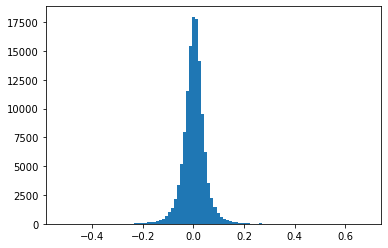

In [161]:
plt.hist(all_deltas, bins=100)
all_deltas = np.nan_to_num(all_deltas)

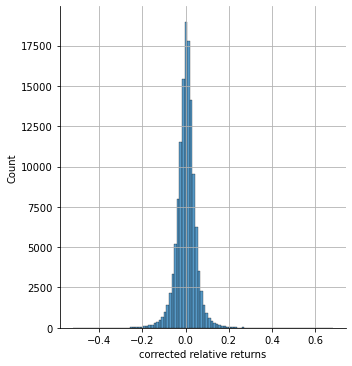

In [173]:
sns.displot(all_deltas, bins=100)
plt.grid()
plt.xlabel('corrected relative returns')
plt.savefig('plots/returns_dist.png')
plt.show()


In [194]:
scipy.stats.describe(all_deltas)

DescribeResult(nobs=127861, minmax=(-0.5213978492917866, 0.6808071553099578), mean=0.002936975741777077, variance=0.002141514687782241, skewness=-0.06296098673018366, kurtosis=7.591148694343385)

In [195]:
np.mean(np.abs(all_deltas))


0.03226775858667886

In [174]:
data_df = preprocessing.format_to_bert()


1 Failed download:
- BF.B: No data found for this date range, symbol may be delisted

1 Failed download:
- BRK.B: No data found, symbol may be delisted
Train DF of size 4954
oldest article: 2020-01-14
save DF to: /Users/marcglettig/MA5/Machinelearning_for_finance/Fin-418-NLFF/data/tabular_data/data_.tsv


In [175]:
data_df.head()

,text,label,date
0,cintas earns 2021 military friendly and milita...,decrease,2020-11-09
1,cintas announces evs technician winners for na...,not relevant,2020-09-29
2,cintas celebrates 2020 custodian of the year w...,not relevant,2020-09-30
3,cintas names bancroft park's self-cleaning res...,not relevant,2020-11-19
4,cintas corporation announces fiscal 2021 secon...,not relevant,2020-12-22


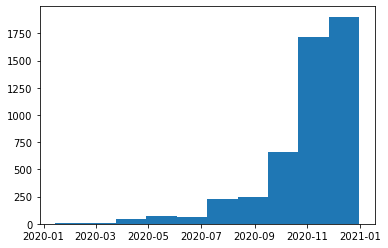

In [176]:
plt.hist(data_df['date'])
plt.show()

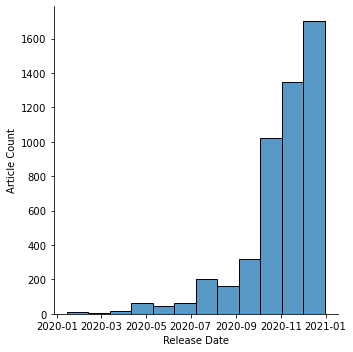

In [186]:
sns.displot(data_df['date'], bins=12)
plt.ylabel('Article Count')
plt.xlabel('Release Date')
plt.savefig('plots/dates_dist.png')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

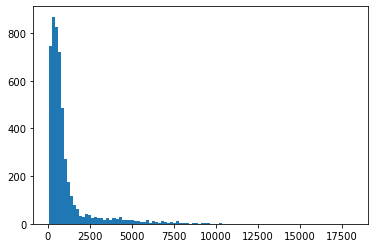

In [187]:
plt.hist(np.vectorize(len)(data_df['text'].apply(lambda x: x.split()).values), bins=100)
plt.show

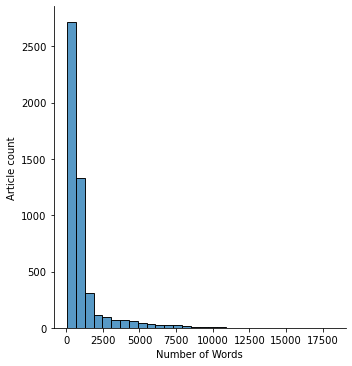

In [193]:
sns.displot(np.vectorize(len)(data_df['text'].apply(lambda x: x.split()).values), bins=30)
plt.xlabel('Number of Words')
plt.ylabel('Article count')
plt.savefig('plots/text_length_dist.png')
plt.show()

In [245]:
grouped = data_df.groupby('label').count().reset_index()
grouped

,label,text,date
0,decrease,425,425
1,increase,529,529
2,not relevant,4000,4000


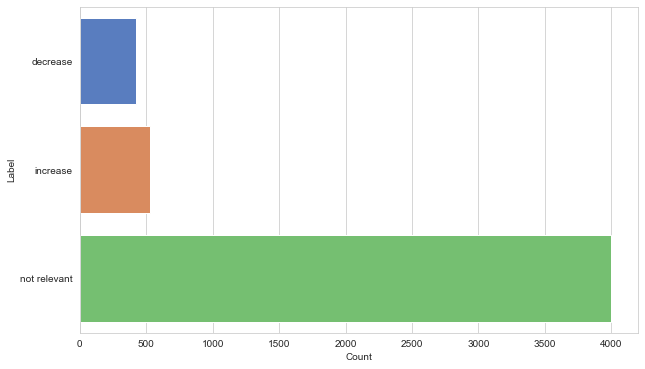

In [261]:
#Seaborn Horizontal barplot
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x='text', y='label', data=grouped, palette="muted",orient='h' )

ax.set_xlabel ("Count")
ax.set_ylabel ("Label")
plt.show()
bar.savefig("plots/label_dist.png");

## Looking at the ARIMA and LSTM data

In [33]:
def to_float(string: str):
    if type(string)==str:
        string = string.strip('[').strip(']')
    return float(string)

In [54]:
arima_data = pd.read_csv('data/tabular_data/prediction_arima_withdate.csv')
arima_data['Date'] = arima_data['Date'].apply(lambda x: dateutil.parser.parse(x))
arima_data.set_index('Date', inplace=True)
for col in arima_data.columns:
    arima_data[col] = arima_data[col].apply(lambda x: to_float(x))
lstm_data = pd.read_csv('data/tabular_data/lstm_pred.csv')
lstm_data['Date'] = lstm_data['Date'].apply(lambda x: dateutil.parser.parse(x))
lstm_data.set_index('Date', inplace=True)

In [55]:
arima_data.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-01,-0.000467,0.001045,-0.005775,-0.000457,-0.000949,-0.002937,0.002628,-0.005797,0.000515,0.002799,...,0.004087,-0.003514,-0.002804,-0.003742,0.003229,0.003044,NaN,0.008892,-0.011674,-0.002351
2020-10-02,0.000798,0.002571,0.002972,0.001425,0.002487,0.008576,0.005977,0.005118,0.000418,-0.004923,...,-0.008521,0.001452,0.002567,0.000535,0.003431,0.001046,NaN,-0.008651,-0.006812,0.003833
2020-10-05,0.004897,0.003448,0.001306,0.012548,0.001638,-0.000697,0.006376,0.002525,0.005720,0.023602,...,0.017500,-0.002871,-0.001480,-0.005741,-0.006484,-0.003212,NaN,0.005287,-0.002960,0.002550
2020-10-06,-0.007757,-0.001476,-0.000092,-0.004952,-0.004982,-0.000617,0.003250,-0.006410,-0.002637,-0.003778,...,-0.010576,-0.006604,-0.000384,-0.003599,0.005156,0.003562,NaN,-0.005182,0.003351,0.001978
2020-10-07,0.005789,-0.010353,-0.000342,0.011733,0.006782,0.004897,0.002135,0.009166,0.005879,0.011089,...,0.003339,-0.001932,0.003242,0.001542,-0.001411,-0.000989,NaN,0.000187,0.006818,0.004590


In [56]:
lstm_data.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-08,0.044484,-0.024163,-0.011208,-0.007579,-0.006428,-0.021936,-0.032452,-0.042213,-0.015041,-0.017350,...,-0.009521,-0.022762,-0.003336,0.023142,-0.004740,-0.009547,-0.000442,0.000020,0.001468,0.000158
2020-10-09,0.008696,-0.039558,-0.061532,0.005215,0.004495,0.009758,0.010226,0.003644,0.003570,-0.005743,...,-0.010558,-0.007619,-0.007586,0.000244,-0.005411,-0.002303,0.000318,0.000384,0.000276,-0.001689
2020-10-12,0.016926,0.058434,0.007241,0.007438,0.001088,0.033377,0.043008,0.024844,0.007527,0.016102,...,0.006034,0.014522,0.025416,0.048479,0.023668,0.017149,0.045866,0.013904,0.044396,0.013820
2020-10-13,0.000088,-0.048078,-0.017773,-0.016161,-0.007820,-0.012785,0.008188,-0.021457,-0.006942,-0.025947,...,-0.010322,-0.016507,-0.001241,-0.004664,-0.004852,0.009293,0.002147,-0.004090,-0.011118,-0.003188
2020-10-14,0.004007,0.008282,0.010764,-0.004441,0.006890,0.020084,0.023160,0.025942,0.046504,0.022754,...,-0.010469,-0.004577,0.007588,0.015359,0.015192,0.009761,0.018612,0.014536,0.011244,-0.001473


In [100]:
aapl_returns = yf.download('AAPL', start='2020-10-08', end='2021-01-01', progress=False)
aapl_returns = aapl_returns['Adj Close'].diff(-1) / aapl_returns['Adj Close']

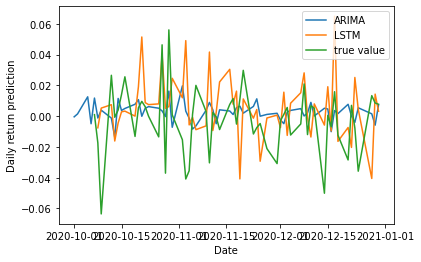

In [101]:
import matplotlib.dates as mdates
months = mdates.MonthLocator()
days = mdates.WeekdayLocator()
months_fmt = mdates.DateFormatter('%M')
plt.plot(arima_data.index, arima_data['AAPL'], label='ARIMA')
plt.plot(lstm_data.index, lstm_data['AAPL'], label='LSTM')
plt.plot(aapl_returns, label='true value')
plt.xlabel('Date')
plt.ylabel('Daily return prediction')
plt.legend()
plt.show()

plt.show()